## Define Model Domains and Import Necessary Data

In [7]:
import os
os.chdir(r"C:\Users\Jason\Downloads\Flowband Code")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import netCDF4 as nc
from scipy import interpolate
from pyproj import Proj, transform
import numpy as np
from scipy.interpolate import griddata
import plotly.graph_objects as go
import xarray as xr
import gstatsim as gs
import rasterio
from scipy.interpolate import RegularGridInterpolator as RGI

import Flowband_Functions as ff

## Load in different datasets

In [2]:
Mv2 = nc.Dataset(r'C:\Users\Jason\Downloads\antarctica_ice_velocity_450m_v2.nc')

CD_GHfx = r"C:\Users\Jason\Desktop\Modeling Data (Sticky Spot)\Geothermal Heat Flux\200km_GHF_windowCenters.val.tiff"
Seis_GHfx = r"C:\Users\Jason\Desktop\Modeling Data (Sticky Spot)\Geothermal Heat Flux\GeothermalHeatFlux_5km.tif"
ALBMAP_GHfx_Fox = r"C:\Users\Jason\Desktop\Modeling Data (Sticky Spot)\ALBMAP\ALBMAP_GeothermalHeatFlux_FoxMaule_5km.tif"
ALBMAP_GHfx_Shapiro = r"C:\Users\Jason\Desktop\Modeling Data (Sticky Spot)\ALBMAP\ALBMAP_GeothermalHeatFlux_ShapiroRitzwoller_5km.tif"

ALBMAP_SurfTemp = r"C:\Users\Jason\Desktop\Modeling Data (Sticky Spot)\ALBMAP\ALBMAP_SurfaceAirTemperature_5km.tif"
RACMO_SurfTemp = r"C:\Users\Jason\Desktop\Modeling Data (Sticky Spot)\Van Wessem RACMO\RACMO_Temperature_2m_35km.tif"

RACMO_Accumulation = r"C:\Users\Jason\Desktop\Modeling Data (Sticky Spot)\Accumulation\precip.KNMI-2011.XPEN055.ERAINx_RACMO2.4.3H.nc"
RACMO_Precipitation = r"C:\Users\Jason\Desktop\Modeling Data (Sticky Spot)\Van Wessem RACMO\RACMO_Precipitation_35km.tif"

RACMO_Sublimation = r"C:\Users\Jason\Desktop\Modeling Data (Sticky Spot)\Van Wessem RACMO\RACMO_Sublimation_Rate_35km.tif"

Basal_Melt_5km = r"C:\Users\Jason\Desktop\Modeling Data (Sticky Spot)\Ice Melt & Friction\waismelt.5km.grd"

SAMBA_SMBalance = r"C:\Users\Jason\Desktop\Modeling Data (Sticky Spot)\SAMBA Surface mass balance measurements\SAMBA_surface_mass_balance_measurements.shp"
RACMO_SMBalance = r"C:\Users\Jason\Desktop\Modeling Data (Sticky Spot)\Van Wessem RACMO\RACMO_SurfaceMassBalance_35km.tif"

flt_surf = r'C:\Users\Jason\Downloads\bedmap2_bin\bedmap2_bin\bedmap2_surface.flt'
hdr_surf = r'C:\Users\Jason\Downloads\bedmap2_bin\bedmap2_bin\bedmap2_surface.hdr'

flt_bed = r'C:\Users\Jason\Downloads\bedmap2_bin\bedmap2_bin\bedmap2_bed.flt'
hdr_bed = r'C:\Users\Jason\Downloads\bedmap2_bin\bedmap2_bin\bedmap2_bed.hdr'

flt_thk = r'C:\Users\Jason\Downloads\bedmap2_bin\bedmap2_bin\bedmap2_thickness.flt'
hdr_thk = r'C:\Users\Jason\Downloads\bedmap2_bin\bedmap2_bin\bedmap2_thickness.hdr'

Johns_bed_path = r"C:\Users\Jason\Desktop\Modeling Data (Sticky Spot)\Beds\John Goff's Conditional Simulation\thwaitsbed_chan_consim4.grd"

bm3_path = r"C:\Users\Jason\Downloads\bm3_bed.tif"

## Open Thwaites Bed Conditional Simulation (Goff et al. 2013)

In [34]:
class Goff:
    
    # Load the .grd file
    data = xr.open_dataset(Johns_bed_path)

    # Access the variable
    print(data)  # This will show the structure of the dataset
    Z = data['z']  # Replace 'variable_name' with the actual name of the data variable
    x_data = data['x']
    y_data = data['y']

    # Convert to numpy array if needed
    Elev = Z.values
    x = x_data.values
    y = y_data.values

    [X,Y] = np.meshgrid(x,y)

<xarray.Dataset>
Dimensions:  (x: 2361, y: 3001)
Coordinates:
  * x        (x) float32 -1.63e+06 -1.63e+06 -1.63e+06 ... -1.04e+06 -1.04e+06
  * y        (y) float32 -9e+05 -8.998e+05 -8.995e+05 ... -1.502e+05 -1.5e+05
Data variables:
    z        (y, x) float32 ...
Attributes:
    Conventions:  COARDS, CF-1.0
    title:        z
    history:      grdmath bedsyn4.grd bedsyn4_samp.grd SUB /disk/staff/goff/d...
    GMT_version:  4.2.1
    node_offset:  0
(3001, 2361)


In [4]:
def build_interpolator(X,Y,Data):
    
    interpolator = RGI((X[0, :], Y[:, 0]), Data.T, method='linear', bounds_error=False, fill_value=None)
    
    return interpolator

import numpy as np
import rasterio

def tif_to_array_with_coords(tif_path):
    """
    Reads a GeoTIFF and returns:
      - data: 2D numpy array
      - X, Y: 2D arrays of projected coordinates (same shape as data)
      - transform: affine transform
      - crs: coordinate reference system
    """
    with rasterio.open(tif_path) as src:
        data = src.read(1)
        transform = src.transform
        crs = src.crs

        # Get pixel indices
        height, width = data.shape
        cols, rows = np.meshgrid(np.arange(width), np.arange(height))

        # Convert pixel coordinates to projected coordinates (center of each pixel)
        X, Y = rasterio.transform.xy(transform, rows, cols)
        X = np.array(X)
        Y = np.array(Y)
    
    return data, X, Y, transform, crs


class bm3:   
    surf_arr, X, Y, transform, crs = tif_to_array_with_coords(r"C:\Users\Jason\Downloads\bm3_surface.tif")
    bed_arr, _, _, _, _ = tif_to_array_with_coords(r"C:\Users\Jason\Downloads\bm3_bed.tif")
    
    x = X[1,:]
    y = Y[:,1]
    
    # The surface's X & Y are the same as the bed's X & Y. So for simplicity I only defined X and Y once.
    # Also same thing with bed transform and crs

## Plot Bedmap3

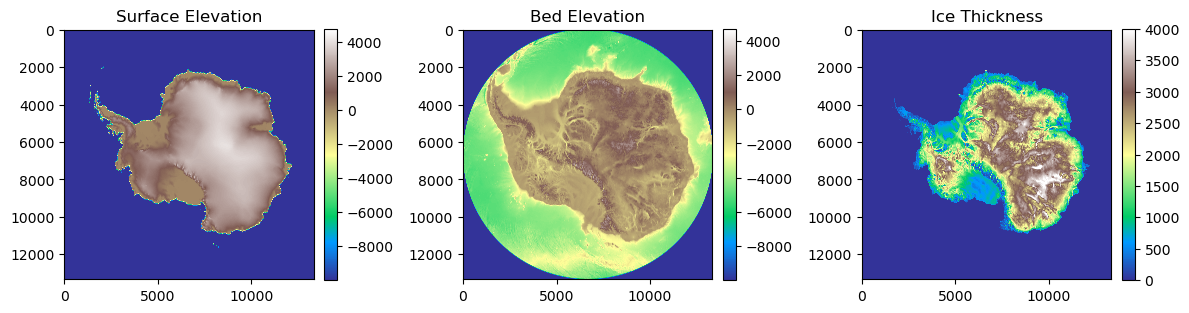

In [5]:
fig, axes = plt.subplots(1, 3, figsize=(12, 6))

surface = bm3.surf_arr
bed = bm3.bed_arr

# Plot surface
im1 = axes[0].imshow(surface, cmap="terrain")
axes[0].set_title("Surface Elevation")
plt.colorbar(im1, ax=axes[0], fraction=0.046, pad=0.04)

# Plot bed
im2 = axes[1].imshow(bed, cmap="terrain")
axes[1].set_title("Bed Elevation")
plt.colorbar(im2, ax=axes[1], fraction=0.046, pad=0.04)

im3 = axes[2].imshow(surface - bed, cmap="terrain", vmin = 0, vmax = 4000)
axes[2].set_title("Ice Thickness")
plt.colorbar(im3, ax=axes[2], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

In [35]:
srf_x, srf_y = bm3.x, bm3.y

def tif_to_array(image_path,x,y):
    
    from PIL import Image
    import numpy as np

    # Load the TIFF image
    image = Image.open(image_path)

    # Convert the image to a NumPy array
    image_array = np.array(image)
    
    image_array = np.nan_to_num(image_array, nan=0)
    
    extent_x = np.linspace(np.min(x),np.max(x),len(image_array[:,0]))
    extent_y = np.linspace(np.min(y),np.max(y),len(image_array[0,:]))
    
    print(np.shape(image_array))
    print(np.shape(x),np.shape(y))

    X,Y = np.meshgrid(extent_x,extent_y)
    
    return image_array, X, Y, extent_x, extent_y

CD_GHfx_data, CD_GHfx_data_X, CD_GHfx_data_Y, CD_GHfx_data_x, CD_GHfx_data_y = tif_to_array(CD_GHfx,srf_x,srf_y)
Seis_GHfx_data, Seis_GHfx_data_X, Seis_GHfx_data_Y, Seis_GHfx_data_x, Seis_GHfx_data_y = tif_to_array(Seis_GHfx,srf_x,srf_y)
ALBMAP_GHfx_Fox_data, SALBMAP_GHfx_Fox_data_X, ALBMAP_GHfx_Fox_data_Y, ALBMAP_GHfx_Fox_data_x, ALBMAP_GHfx_Fox_data_y  = tif_to_array(ALBMAP_GHfx_Fox,srf_x,srf_y)
ALBMAP_GHfx_Shapiro_data,ALBMAP_GHfx_Shapiro_data_X,ALBMAP_GHfx_Shapiro_data_Y,ALBMAP_GHfx_Shapiro_data_x,ALBMAP_GHfx_Shapiro_data_y = tif_to_array(ALBMAP_GHfx_Shapiro,srf_x,srf_y)

# ---------------------------------------------------------------------------

def new_tif_to_array(image_path,x=[],y=[],set_extents=False):
    
    from PIL import Image
    import numpy as np

    # Load the TIFF image
    image = Image.open(image_path)

    # Convert the image to a NumPy array
    image_array = np.array(image)
    
    image_array = np.nan_to_num(image_array, nan=0)
    
    if set_extents == True:
    
        extent_x = np.linspace(np.min(x),np.max(x),len(image_array[:,0]))
        extent_y = np.linspace(np.min(y),np.max(y),len(image_array[0,:]))
        
        print(np.shape(image_array))
        print(np.shape(x),np.shape(y))
    
        X,Y = np.meshgrid(extent_x,extent_y)
        
        return image_array, X, Y, extent_x, extent_y

    else:
        return image_array

RACMO_Accumulation = r"C:\Users\Jason\Desktop\Modeling Data (Sticky Spot)\Accumulation\precip.KNMI-2011.XPEN055.ERAINx_RACMO2.4.3H.nc"
RACMO_Precipitation = r"C:\Users\Jason\Desktop\Modeling Data (Sticky Spot)\Van Wessem RACMO\RACMO_Precipitation_35km.tif"
RACMO_Sublimation = r"C:\Users\Jason\Desktop\Modeling Data (Sticky Spot)\Van Wessem RACMO\RACMO_Sublimation_Rate_35km.tif"
Basal_Melt_5km = r"C:\Users\Jason\Desktop\Modeling Data (Sticky Spot)\Ice Melt & Friction\waismelt.5km.grd"
SAMBA_SMBalance = r"C:\Users\Jason\Desktop\Modeling Data (Sticky Spot)\SAMBA Surface mass balance measurements\SAMBA_surface_mass_balance_measurements.shp"
RACMO_SMBalance = r"C:\Users\Jason\Desktop\Modeling Data (Sticky Spot)\Van Wessem RACMO\RACMO_SurfaceMassBalance_35km.tif"

ALBMAP_SurfTemp = r"C:\Users\Jason\Desktop\Modeling Data (Sticky Spot)\ALBMAP\ALBMAP_SurfaceAirTemperature_5km.tif"
RACMO_SurfTemp = r"C:\Users\Jason\Desktop\Modeling Data (Sticky Spot)\Van Wessem RACMO\RACMO_Temperature_2m_35km.tif"

ALBMAP_Acc = r"C:\Users\Jason\Desktop\Modeling Data (Sticky Spot)\ALBMAP\ALBMAP_SnowAccumulation_Arthern_5km.tif"
ALBMAP_AccV = r"C:\Users\Jason\Desktop\Modeling Data (Sticky Spot)\ALBMAP\ALBMAP_SnowAccumulation_VanDeBerg_5km.tif"

ALB_Ts = new_tif_to_array(ALBMAP_SurfTemp)
RAC_Ts = new_tif_to_array(RACMO_SurfTemp)

# RACMO netCDF

RA = nc.Dataset(RACMO_Accumulation, 'r')
    
RA_lat = np.squeeze(RA['lat'][0:10][0:10][0:10].data)
RA_lon = np.squeeze(RA['lon'][0:10][0:10][0:10].data)
RA_precip = np.squeeze(RA['precip'][0:10][0:10][0:10].data)

# Loading in the Joughin et al. Data -----------------------------------------------------------------------

# Load the .grd file
BM = xr.open_dataset(Basal_Melt_5km)

# Access the variable
# print(BM)  # This will show the structure of the dataset
BM_data = BM['z']  # Replace 'variable_name' with the actual name of the data variable
x_data_melt = BM['x']
y_data_melt = BM['y']

Melt = BM_data.values
x = x_data_melt.values
y = y_data_melt.values

# Loading in ALMAP and RACMO Data ---------------------------------------------------------------------------

R_SMB = new_tif_to_array(RACMO_SMBalance)
ALB_Aa = new_tif_to_array(ALBMAP_Acc)
ALB_Av = new_tif_to_array(ALBMAP_AccV)

# -------------------------------------------------------------------

def build_grid(extents_x,extents_y,resolution,r='all'):
    import numpy as np
    
    range_x = extents_x[1] - extents_x[0]
    range_y = extents_y[1] - extents_y[0]
    
    x = np.linspace(extents_x[0],extents_x[1],round(np.abs(range_x)/resolution))
    y = np.linspace(extents_y[0],extents_y[1],round(np.abs(range_y)/resolution))
    
    X, Y = np.meshgrid(x,y)
    
    if r == 'grid only':
        return X, Y
    else: 
        return X, Y, x, y

class ALBMAP:
    x = []
    y = []
    X = []
    Y = []
    extent_x = [-2800000,3000000]
    extent_y = [2800000,-2800000]
    res = 5000 # resolution in meters (5 km)
    Shapiro_Gflux = ALBMAP_GHfx_Shapiro_data
    Accum_Arth = ALB_Aa
    Accum_Van = ALB_Av
    
class MELT:
    Data = Melt
    x = x_data_melt.values
    y = y_data_melt.values
    X, Y = np.meshgrid(x,y)
    
class CD:
    Data = CD_GHfx_data
    extents_x = [-2005000, -495000]
    extents_y = [405000, -1005000]
    res = 10000
    
ALBMAP.X,ALBMAP.Y,ALBMAP.x,ALBMAP.y = build_grid(ALBMAP.extent_x,ALBMAP.extent_y,ALBMAP.res)
CD.X,CD.Y,CD.x,CD.y = build_grid(CD.extents_x,CD.extents_y,CD.res)
# RACMO.X,RACMO.Y,RACMO.x,RACMO.y = build_grid(ALBMAP.extent_x,ALBMAP.extent_y,RACMO.res)


ALBMAP.Ts = ALB_Ts
ALBMAP.FG = ALBMAP_GHfx_Fox_data
# RACMO.SMB = R_SMB

print(ALBMAP.X.shape)
print(ALBMAP.Ts.shape)

print(Melt.shape)
print(MELT.Data.shape)
print(MELT.X.shape)

interp_Melt = build_interpolator(MELT.X,MELT.Y,MELT.Data)
interp_SG = build_interpolator(ALBMAP.X,ALBMAP.Y,ALBMAP.Shapiro_Gflux)
interp_AA = build_interpolator(ALBMAP.X,ALBMAP.Y,ALBMAP.Accum_Arth)
interp_AV = build_interpolator(ALBMAP.X,ALBMAP.Y,ALBMAP.Accum_Van)
interp_Ts = build_interpolator(ALBMAP.X,ALBMAP.Y,ALBMAP.Ts)
interp_FG = build_interpolator(ALBMAP.X,ALBMAP.Y,ALBMAP.FG)
interp_CD = build_interpolator(CD.X,CD.Y,CD.Data)

interp_Goff = build_interpolator(Goff.X,Goff.Y,Goff.Elev)

# ------------------------------------------------------------------------

# def tif_to_array(tif_path):
#     """
#     Reads a GeoTIFF (.tif) file (and its .tfw if present)
#     and returns:
#       - data: numpy array of raster values
#       - transform: affine transform (for pixel <-> geographic coords)
#       - crs: coordinate reference system
#     """
#     with rasterio.open(tif_path) as src:
#         data = src.read(1)  # read first band
#         transform = src.transform
#         crs = src.crs
        
#         # Get pixel indices
#         height, width = data.shape
#         cols, rows = np.meshgrid(np.arange(width), np.arange(height))

#         # Convert pixel coordinates to projected coordinates (center of each pixel)
#         X, Y = rasterio.transform.xy(transform, rows, cols)
#         X = np.array(X)
#         Y = np.array(Y)
    
#     return data, X, Y, transform, crs

(141, 151)
(13334,) (13334,)
(1335, 1335)
(13334,) (13334,)
(1120, 1160)
(13334,) (13334,)
(1120, 1160)
(13334,) (13334,)
(1120, 1160)
(1120, 1160)
(235, 326)
(235, 326)
(235, 326)


## Plot Thwaites Region

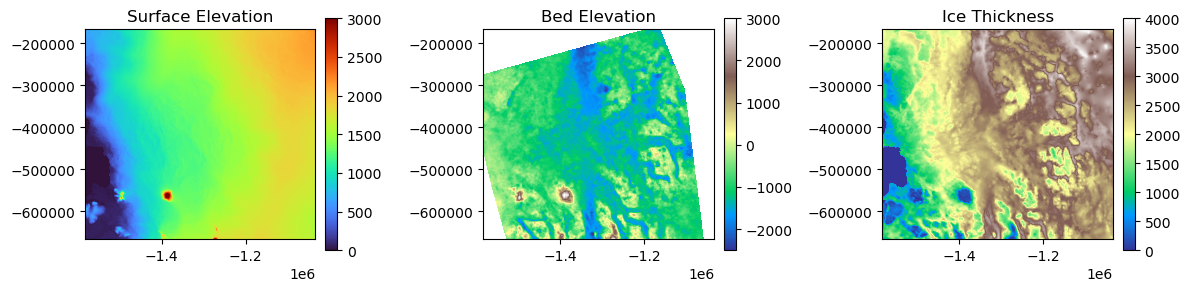

In [36]:
THW_surface = surface[7000:8000, 3500:4600]  # Proper 2D slicing
# THW_bed = bed[7000:8000, 3500:4600]   
THW_thk = THW_surface - THW_bed

THW_X, THW_Y = bm3.X[7000:8000, 3500:4600], bm3.Y[7000:8000, 3500:4600]

bm3.bed_interp = build_interpolator(THW_X, THW_Y, THW_bed)
bm3.surf_interp = build_interpolator(THW_X, THW_Y, THW_surface)
bm3.thk_interp = build_interpolator(THW_X, THW_Y, THW_thk)

THW_bed = interp_Goff((THW_X, THW_Y))

fig, axes = plt.subplots(1, 3, figsize=(12, 6))

# Plot surface
im1 = axes[0].imshow(THW_surface, vmin=0, vmax=3000, extent=(THW_X.min(), THW_X.max(), THW_Y.min(), THW_Y.max()), cmap="turbo")
axes[0].set_title("Surface Elevation")
plt.colorbar(im1, ax=axes[0], fraction=0.046, pad=0.04)

# Plot bed
im2 = axes[1].imshow(THW_bed, vmin=-2500, vmax=3000, extent=(THW_X.min(), THW_X.max(), THW_Y.min(), THW_Y.max()), cmap="terrain")
axes[1].set_title("Bed Elevation")
plt.colorbar(im2, ax=axes[1], fraction=0.046, pad=0.04)

im3 = axes[2].imshow(THW_thk, vmin=0, vmax=4000, extent=(THW_X.min(), THW_X.max(), THW_Y.min(), THW_Y.max()), cmap="terrain")
axes[2].set_title("Ice Thickness")
plt.colorbar(im3, ax=axes[2], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

In [37]:
xlim = [np.min(THW_X), np.max(THW_X)]  # X-coordinate limits
ylim = [np.min(THW_Y), np.max(THW_Y)]   # Y-coordinate limits

Mv2_x = Mv2['x'][:].data
Mv2_y = Mv2['y'][:].data

xindex = np.where((Mv2_x > xlim[0]) & (Mv2_x < xlim[1]))
yindex = np.where((Mv2_y > ylim[0]) & (Mv2_y < ylim[1]))

x_filtered = Mv2_x[xindex]
y_filtered = Mv2_y[yindex]

Xc,Yc = np.meshgrid(x_filtered,y_filtered)

print(np.size(x_filtered))

vx_filtered = np.squeeze(Mv2['VX'][yindex][:,xindex].data)
vy_filtered = np.squeeze(Mv2['VY'][yindex][:,xindex].data)
errx_filtered = np.squeeze(Mv2['ERRX'][yindex][:,xindex].data)
erry_filtered = np.squeeze(Mv2['ERRY'][yindex][:,xindex].data)
stdx_filtered = np.squeeze(Mv2['STDX'][yindex][:,xindex].data)
stdy_filtered = np.squeeze(Mv2['STDY'][yindex][:,xindex].data)

erry_filtered[np.isnan(erry_filtered)] = 0 # Sets all NaN values to zero, we'll see if this fixes things
errx_filtered[np.isnan(errx_filtered)] = 0

fvx = RGI((x_filtered, y_filtered), vx_filtered.T, method='cubic', bounds_error=False)
fvy = RGI((x_filtered, y_filtered), vy_filtered.T, method='cubic', bounds_error=False)

ferrvx = RGI((x_filtered, y_filtered), errx_filtered.T, method='cubic', bounds_error=False)
ferrvy = RGI((x_filtered, y_filtered), erry_filtered.T, method='cubic', bounds_error=False)

fstdvx = RGI((x_filtered, y_filtered), stdx_filtered.T, method='cubic', bounds_error=False)
fstdvy = RGI((x_filtered, y_filtered), stdy_filtered.T, method='cubic', bounds_error=False)

1221


## Plot the chosen domain over the data

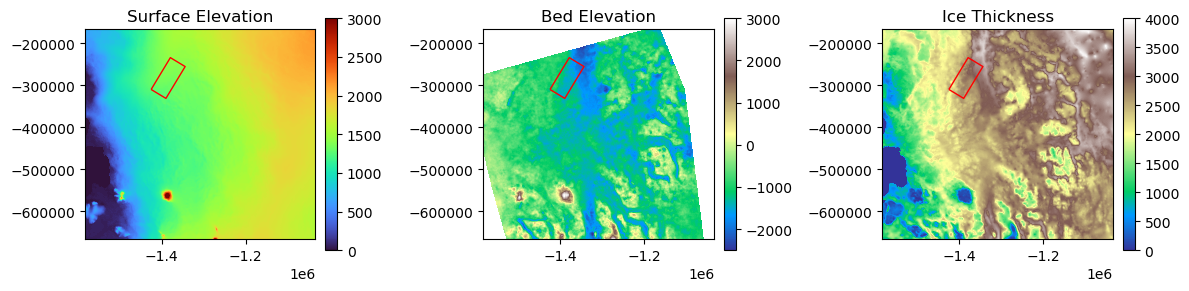

In [38]:
import geopandas as gpd

# Read the geopackage (can contain multiple layers)
gdf = gpd.read_file(r"C:\Users\Jason\Downloads\domain1_trial.gpkg")   # or specify layer="name"

fig, axes = plt.subplots(1, 3, figsize=(12, 6))

# Plot surface
im1 = axes[0].imshow(THW_surface, vmin=0, vmax=3000, extent=(THW_X.min(), THW_X.max(), THW_Y.min(), THW_Y.max()), cmap="turbo")
gdf.boundary.plot(ax=axes[0], color="red", linewidth=1)
axes[0].set_title("Surface Elevation")
plt.colorbar(im1, ax=axes[0], fraction=0.046, pad=0.04)

# Plot bed
im2 = axes[1].imshow(THW_bed, vmin=-2500, vmax=3000, extent=(THW_X.min(), THW_X.max(), THW_Y.min(), THW_Y.max()), cmap="terrain")
axes[1].set_title("Bed Elevation")
gdf.boundary.plot(ax=axes[1], color="red", linewidth=1)
plt.colorbar(im2, ax=axes[1], fraction=0.046, pad=0.04)

im3 = axes[2].imshow(THW_thk, vmin=0, vmax=4000, extent=(THW_X.min(), THW_X.max(), THW_Y.min(), THW_Y.max()), cmap="terrain")
axes[2].set_title("Ice Thickness")
gdf.boundary.plot(ax=axes[2], color="red", linewidth=1)
plt.colorbar(im3, ax=axes[2], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

In [39]:
domain = gdf.unary_union  # merge all geometries if multiple

# Bounding box of domain
minx, miny, maxx, maxy = domain.bounds

extents = [minx, miny, maxx, maxy]

# Desired grid spacing (in coordinate units, e.g. meters or degrees)
dx = dy = 100  # adjust as needed

print(extents)

x = np.arange(minx, maxx + dx, dx)
y = np.arange(miny, maxy + dy, dy)
X, Y = np.meshgrid(x, y)

np.shape(X)

[-1424763.1959158282, -331112.38769095606, -1343776.3020062083, -234039.69574037404]


(972, 811)

Corners:
 [[-1424760.          -309800.        ]
 [-1378426.19358626  -232885.8813532 ]
 [-1341645.95728264  -258632.04676573]
 [-1387979.76369638  -335546.16541254]]


125000

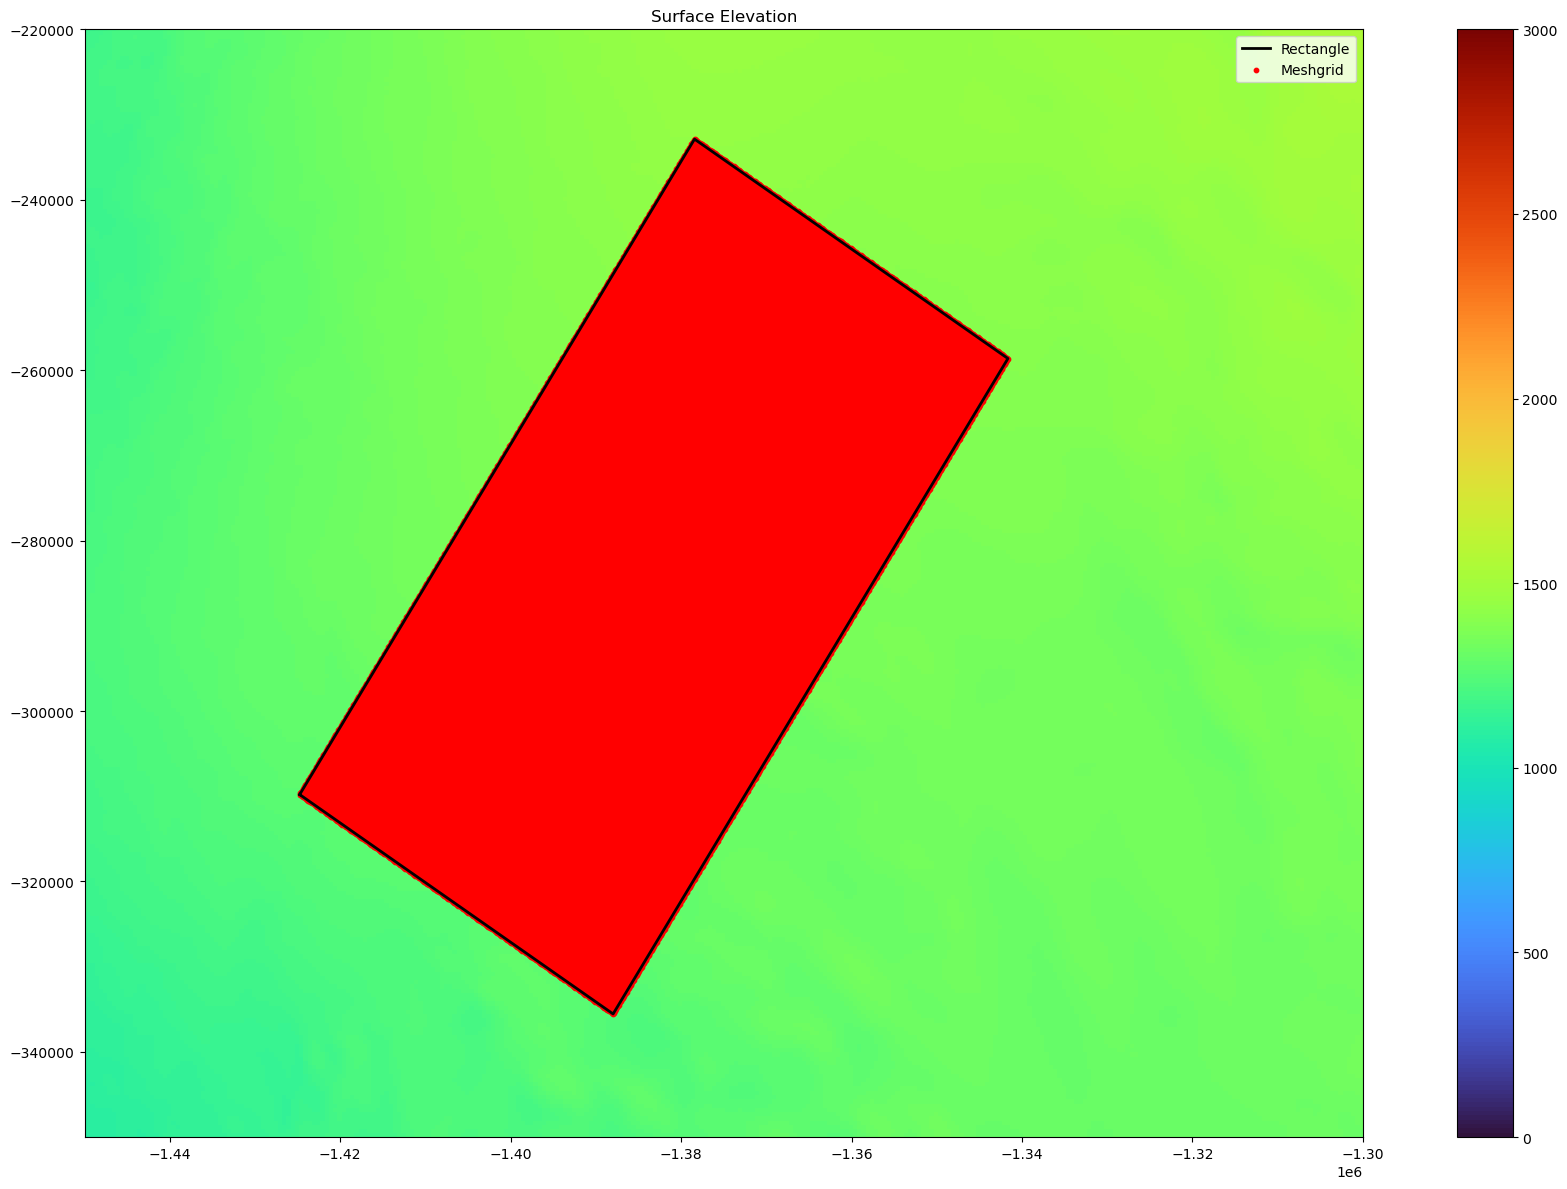

In [40]:
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Polygon

def tilted_rectangle(x0, y0, m_x, m_y, Lx, Ly):
    """
    Compute the 4 corner coordinates of a tilted rectangle defined by:
      - SW corner (x0, y0)
      - Slopes m_x (east-west edge) and m_y (north-south edge)
      - Lengths Lx, Ly along those directions
    Returns corners in order [SW, SE, NE, NW]
    """
    dx = np.array([1, m_x]) / np.sqrt(1 + m_x**2)
    dy = np.array([1, m_y]) / np.sqrt(1 + m_y**2)

    P_SW = np.array([x0, y0])
    P_SE = P_SW + Lx * dx
    P_NW = P_SW + Ly * dy
    P_NE = P_NW + Lx * dx

    return np.vstack([P_SW, P_SE, P_NE, P_NW])


def meshgrid_from_tilted_rectangle(corners, nx=50, ny=50):
    """
    Create an evenly spaced meshgrid inside a tilted rectangle
    defined by its 4 corners [SW, SE, NE, NW].
    """
    P_SW, P_SE, P_NE, P_NW = corners

    # Parametric grid (u,v in [0,1])
    u = np.linspace(0, 1, nx)
    v = np.linspace(0, 1, ny)
    U, V = np.meshgrid(u, v)

    # Bilinear interpolation
    X = ((1 - U) * (1 - V)) * P_SW[0] + (U * (1 - V)) * P_SE[0] + \
        ((1 - U) * V) * P_NW[0] + (U * V) * P_NE[0]
    Y = ((1 - U) * (1 - V)) * P_SW[1] + (U * (1 - V)) * P_SE[1] + \
        ((1 - U) * V) * P_NW[1] + (U * V) * P_NE[1]

    return X, Y




# === Example usage ===
x0, y0 = -1.42476e6, -3.098e5      # southwest corner
m_x, m_y = 1.66, -0.7   # slopes
Lx, Ly = 89792, 89792/2    # extents
nx, ny = 500, 250       # grid resolution

# Step 1: Get corners
corners = tilted_rectangle(x0, y0, m_x, m_y, Lx, Ly)

# Step 2: Build meshgrid inside tilted polygon
X_mask, Y_mask = meshgrid_from_tilted_rectangle(corners, nx, ny)

fig, ax = plt.subplots(1, figsize=(24, 12))

idx = (-1,-1)

# Plot surface
im1 = ax.imshow(THW_surface, vmin=0, vmax=3000, extent=(THW_X.min(), THW_X.max(), THW_Y.min(), THW_Y.max()), cmap="turbo")
# gdf.boundary.plot(ax=ax, color="red", linewidth=1)
ax.set_title("Surface Elevation")
plt.colorbar(im1, ax=ax, fraction=0.046, pad=0.04)
ax.plot(*zip(*(list(corners) + [corners[0]])), 'k-', lw=2, label='Rectangle')
ax.scatter(X_mask, Y_mask, s=10, c='red', label='Meshgrid')
ax.set_xlim(-1.45e6,-1.3e6)
ax.set_ylim(-3.5e5,-2.2e5)

ax.legend()
plt.tight_layout()

# Optional polygon object for later use
poly = Polygon(corners)
print("Corners:\n", corners)

np.size(X_mask.flatten())

In [48]:
bed_mask = interp_Goff((X_mask,Y_mask))
surf_mask = bm3.surf_interp((X_mask,Y_mask))
thk_mask = bm3.thk_interp((X_mask,Y_mask))

Vx = fvx((X_mask.flatten(),Y_mask.flatten()))
Vy = fvy((X_mask.flatten(),Y_mask.flatten()))

V_mask = np.sqrt(Vx**2 + Vy**2)

print('interpolation successful')

interpolation successful


In [49]:
Gflux_CD = interp_CD((X_mask, Y_mask))
Bdot = interp_AV((X_mask, Y_mask))
Melt = interp_Melt((X_mask, Y_mask))

In [50]:
def distance(pt1,pt2):
    return np.sqrt((pt2[0] - pt1[0])**2  +((pt2[1] - pt1[1])**2))

# distance(sw,nw)

## Find Bottom Right Corner and Normalize the Domain 

#### (Seems Simplest to Work in Normalized Coordinates)

In [51]:
# idx = np.where(X_mask == X_mask.min())

# new_X_mask = X_mask - X_mask[idx[0]]
# new_Y_mask = Y_mask - Y_mask[idx[0]]

diagonal = np.sqrt((X_mask.max()-X_mask.min())*(X_mask.max()-X_mask.min())
                   + (Y_mask.max()-Y_mask.min())*(Y_mask.max()-Y_mask.min()))   

X_prime = (X_mask - X_mask.min())/(diagonal) 
Y_prime = (Y_mask - Y_mask.min())/(diagonal)

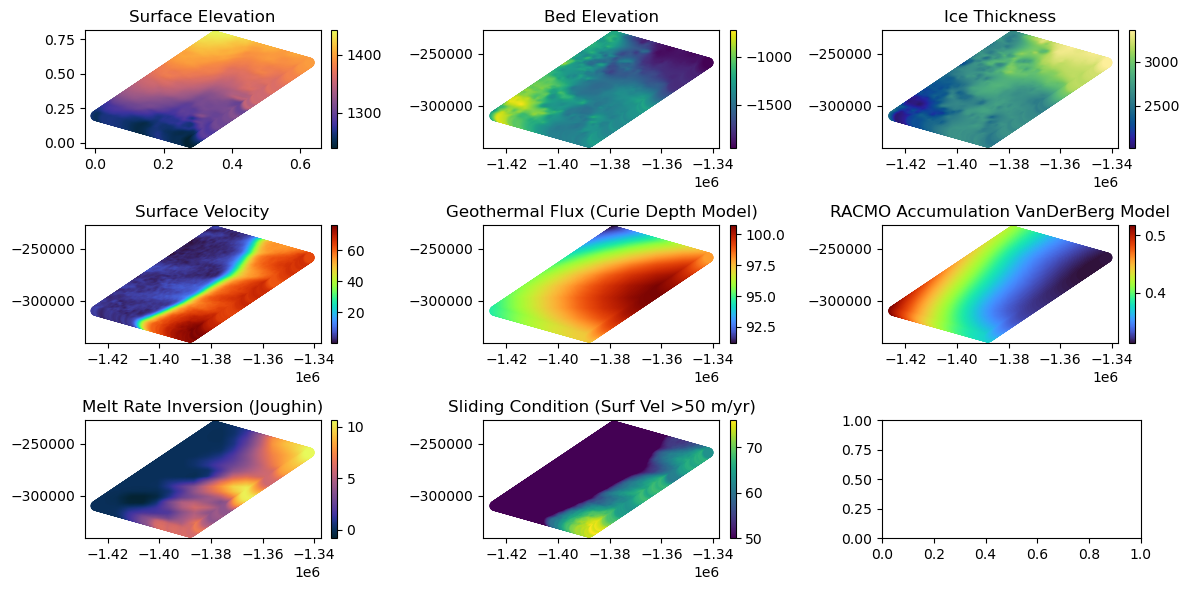

In [45]:
fig, ax = plt.subplots(3, 3, figsize=(12, 6))

im1 = ax[0,0].scatter(X_prime,Y_prime, c = surf_mask, cmap = 'cmo.thermal')
plt.colorbar(im1, ax=ax[0,0], fraction=0.046, pad=0.04)
ax[0,0].set_title("Surface Elevation")

im2 = ax[0,1].scatter(X_mask,Y_mask, c = bed_mask, cmap = 'viridis')
plt.colorbar(im2, ax=ax[0,1], fraction=0.046, pad=0.04)
ax[0,1].set_title("Bed Elevation")

im3 = ax[0,2].scatter(X_mask,Y_mask, c = thk_mask, cmap = 'cmo.haline')
plt.colorbar(im3, ax=ax[0,2], fraction=0.046, pad=0.04)
ax[0,2].set_title("Ice Thickness")

im4 = ax[1,0].scatter(X_mask,Y_mask, c = V_mask, cmap = 'turbo')
plt.colorbar(im4, ax=ax[1,0], fraction=0.046, pad=0.04)
ax[1,0].set_title("Surface Velocity")

im5 = ax[1,1].scatter(X_mask,Y_mask, c = Gflux_CD, cmap = 'turbo')
plt.colorbar(im5, ax=ax[1,1], fraction=0.046, pad=0.04)
ax[1,1].set_title("Geothermal Flux (Curie Depth Model)")

im6 = ax[1,2].scatter(X_mask,Y_mask, c = Bdot, cmap = 'turbo')
plt.colorbar(im6, ax=ax[1,2], fraction=0.046, pad=0.04)
ax[1,2].set_title("RACMO Accumulation VanDerBerg Model")

im7 = ax[2,0].scatter(X_mask,Y_mask, c = Melt, cmap = 'cmo.thermal')
plt.colorbar(im7, ax=ax[2,0], fraction=0.046, pad=0.04)
ax[2,0].set_title("Melt Rate Inversion (Joughin)")

im8 = ax[2,1].scatter(X_mask,Y_mask, c = V_mask, cmap = 'viridis',vmin = 50, vmax = V_mask.max())
plt.colorbar(im8, ax=ax[2,1], fraction=0.046, pad=0.04)
ax[2,1].set_title("Sliding Condition (Surf Vel >50 m/yr)")


plt.tight_layout()
plt.show()

In [52]:
Nx, Ny = (250,500)

data = {
    'X': X_mask.ravel(),
    'Y': Y_mask.ravel(),
    "X'": X_prime.ravel(),
    "Y'": Y_prime.ravel(),
    'Surface': surf_mask.ravel(),
    'Bed': bed_mask.ravel(),
    'Thk': thk_mask.ravel(),
    'Surface Velocity': V_mask.ravel(),
    'Gflux': Gflux_CD.ravel(),
    'Accumulation Rate': Bdot.ravel(),
    'Basal Melt': Melt.ravel(),
}

df = pd.DataFrame(data)
df.attrs['original_shape (Nx,Ny)'] = (Nx, Ny)

df.to_csv('Fenics_model_data_(250x500).csv', index=False)

df.head()

,X,Y,X',Y',Surface,Bed,Thk,Surface Velocity,Gflux,Accumulation Rate,Basal Melt
0,-1.424760e+06,-309800.000000,0.000000,0.194918,1262.820000,-1177.545485,2458.528000,4.905400,94.582629,0.516792,-0.000002
1,-1.424667e+06,-309645.863490,0.000703,0.196085,1263.250839,-1173.140333,2470.557431,5.006359,94.593985,0.516457,-0.000003
2,-1.424574e+06,-309491.726979,0.001406,0.197252,1263.681679,-1176.398132,2483.569842,5.098410,94.605343,0.516121,-0.000003
3,-1.424481e+06,-309337.590469,0.002109,0.198418,1264.112518,-1162.800320,2497.269233,5.184372,94.616706,0.515786,-0.000004
4,-1.424389e+06,-309183.453959,0.002812,0.199585,1264.410266,-1159.065375,2511.485623,5.208682,94.628072,0.515450,-0.000004


In [37]:
import plotly.graph_objects as go

fig = go.Figure()

# --- Bed surface ---
fig.add_trace(
    go.Surface(
        x=X_mask,
        y=Y_mask,
        z= bed_mask * 15,# 1 + bed_mask / surf_mask.max(),
        colorscale='viridis',
        colorbar=dict(title="Bed elevation (m ×20)"),
        name='Bed',
        showscale=True,
        opacity=0.9
    )
)

# --- Surface elevation ---
fig.add_trace(
    go.Surface(
        x=X_mask,
        y=Y_mask,
        z=surf_mask * 15, # / surf_mask.max(),
        colorscale='inferno',
        name='Surface',
        showscale=False,  # Hide second colorbar
        opacity=0.7
    )
)

# --- Layout ---
fig.update_layout(
    title="3D Bed and Surface Elevation Surfaces",
    scene=dict(
        xaxis_title="X (m)",
        yaxis_title="Y (m)",
        zaxis_title="Elevation (m ×20)",
        aspectmode="data"
    ),
    legend=dict(
        x=0.02, y=0.98,
        bgcolor='rgba(255,255,255,0.7)',
        bordercolor='gray'
    ),
    height=900
)

fig.show()


In [288]:
import pyvista as pv

surf = pv.StructuredGrid(X_prime, Y_prime, surf_mask / surf_mask.max())
# surf.save('surface.stl')

surf.plot(show_edges=True, cmap='terrain')

ImportError: cannot import name 'TypeIs' from 'typing_extensions' (C:\Users\Jason\anaconda3\Lib\site-packages\typing_extensions.py)

In [187]:
# bottom_left = np.where(X_mask == X_mask.min())
# bottom_right = np.where(Y_mask == Y_mask.min())

# top_left = np.where(Y_mask == Y_mask.max())

# print(np.sqrt((X_mask[bottom_left] - X_mask[bottom_right])**2  +((Y_mask[bottom_left] - Y_mask[bottom_right])**2)))

# print(np.sqrt((X_mask[bottom_left] - X_mask[0])**2  + ( (Y_mask[bottom_left] - Y_mask[0])**2)))

# top_left

[38137.90765105]
[83907.6873713]


(array([0, 1, 2], dtype=int64),)

In [ ]:
# dx = np.nanmean(np.diff(X_mask, axis=0))
# dy = np.nanmean(np.diff(Y_mask, axis=0))

# dx = distance([X_mask[2],Y_mask[2]],[X_mask[7],Y_mask[7]])

# bottom_left = np.where(X_mask == X_mask.min())
# bottom_right = np.where(Y_mask == Y_mask.min())

# top_left = np.where(Y_mask == Y_mask.max())

# x_distance = np.sqrt((X_mask[bottom_left] - X_mask[bottom_right])**2  +((Y_mask[bottom_left] - Y_mask[bottom_right])**2))

# y_distance = np.sqrt((X_mask[bottom_left] - X_mask[0])**2  + ( (Y_mask[bottom_left] - Y_mask[0])**2))

# Nx = np.abs(int(x_distance / dx))
# Ny = np.abs(int(y_distance / dy))

# # plt.scatter(X_mask[0:5],Y_mask[0:5],c= 'black')
# # plt.scatter(X_mask[0],Y_mask[0],c= 'blue')
# # plt.scatter(X_mask[4],Y_mask[4],c= 'orange')
# # plt.scatter(X_mask[6:10],Y_mask[6:10],c= 'black')
# # plt.scatter(X_mask[11:30],Y_mask[11:30],c= 'black')

# plt.scatter(X_mask[0:90],Y_mask[0:90],c= 'black')
# plt.scatter(X_mask[7],Y_mask[7],c= 'blue')
# plt.scatter(X_mask[2],Y_mask[2],c= 'orange')

# dx

In [85]:
# Xx, Yy = np.meshgrid(new_X_mask, new_Y_mask)

# Xx, Yy

(array([[11000., 10500., 11000., ...,     0.,   500.,     0.],
        [11000., 10500., 11000., ...,     0.,   500.,     0.],
        [11000., 10500., 11000., ...,     0.,   500.,     0.],
        ...,
        [11000., 10500., 11000., ...,     0.,   500.,     0.],
        [11000., 10500., 11000., ...,     0.,   500.,     0.],
        [11000., 10500., 11000., ...,     0.,   500.,     0.]]),
 array([[96500., 96500., 96500., ..., 96500., 96500., 96500.],
        [96000., 96000., 96000., ..., 96000., 96000., 96000.],
        [96000., 96000., 96000., ..., 96000., 96000., 96000.],
        ...,
        [  500.,   500.,   500., ...,   500.,   500.,   500.],
        [  500.,   500.,   500., ...,   500.,   500.,   500.],
        [    0.,     0.,     0., ...,     0.,     0.,     0.]]))

In [88]:
# import plotly.graph_objects as go

# fig = go.Figure()

# # --- Bed trace ---
# fig.add_trace(
#     go.Surface(
#         x=Xx,
#         y=Yy,
#         z=np.reshape(bed_mask*20,np.shape(Xx)),
#         mode='markers',
#         name='Bed',
#         marker=dict(
#             size=2,
#             color=bed_mask,
#             colorscale='viridis',
#             colorbar=dict(title="Elevation (m)"),
#             opacity=0.8
#         )
#     )
# )

ValueError: cannot reshape array of size 14569 into shape (14569,14569)

In [231]:
# from rasterio import features

# transform = bm3.transform

# # Create a mask with the same shape as the raster
# mask = features.geometry_mask(
#     geometries=gdf.geometry,
#     transform=transform,
#     invert=True,          # True keeps inside polygon
#     out_shape = np.shape(bm3.bed_arr)
# )

# # Surface Values within Domain
# surf_mask = np.where(mask, bm3.surf_arr, np.nan)
# surf_mask = surf_mask[~np.isnan(surf_mask)]

# # Bed Values within Domain
# bed_mask = np.where(mask, bm3.bed_arr, np.nan)
# bed_mask = bed_mask[~np.isnan(bed_mask)]

# # X Values within Domain
# X_mask = np.where(mask, bm3.X, np.nan)
# X_mask = X_mask[~np.isnan(X_mask)]

# # Y Values within Domain
# Y_mask = np.where(mask, bm3.Y, np.nan)
# Y_mask = Y_mask[~np.isnan(Y_mask)]

In [232]:
# SW -> NW = -2674957.58 + 1.66x
# NW -> NE = 23406215.456 - 18.2x
# SW -> SE = 25620835.599999998 - 18.2x
# SE -> NE = -2616417.6 + 1.66x

#NE = point of interection between NW -> NE and SE -> NE

# -2616417.6 + 1.66x = 23406215.456 - 18.2x
#  19.86x = 26022633.056
# x = 1310303.7792547836


nw = (-1298915.08, -234039)
sw = (-1424763, -309851) # line: 1.66x = y, sw was the set point, 1.66 was chosen to best match the QGIS drawn domain
# an arbitrary x-displacement was chosen (75812) to best match QGIS drawn model domain

se = (-1389550,-309764.6)

In [301]:
print("point 1:",X_prime[0,0],',',Y_prime[0,1],'\n')
print("point 2:",X_prime[1,0],',',Y_prime[1,0],'\n')

print("rise:", Y_prime[1,0] - Y_prime[0,0])
print("run", X_prime[1,0] - X_prime[0,0],'\n')

print("dx:", np.sqrt((Y_prime[1,0] - Y_prime[0,0])**2 + (X_prime[1,0] - X_prime[0,0])**2))

point 1: 0.0 , 0.20079945663632226 

point 2: 0.005682730802946573 , 0.1909397549790098 

rise: -0.003977911562062786
run 0.005682730802946573 

dx: 0.006936656959541145
